# Debug the cues computation

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time

2025-02-28 14:51:24.322264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [63]:
interrogation_window_size = (100,100)

***

## Initializations

### Prepare specifications for pykitPIV parameters

In [190]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [217]:
flowfield_spec = FlowFieldSpecs(size=(200, 300),
                                flowfield_type='random smooth',
                                gaussian_filters=(3, 3),
                                n_gaussian_filter_iter=5,
                                displacement=(2, 2), 
                                random_seed=100)

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=100,
flowfield_type='random smooth',
gaussian_filters=(3, 3),
n_gaussian_filter_iter=5,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [218]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [219]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


In [220]:
sample_every_n = 5

In [221]:
cues_obj = Cues(sample_every_n=sample_every_n, 
                normalize_displacement_vectors=False)

cues_function = cues_obj.sampled_vectors

### Prepare the CNN-based inference model for PIV images:

In [222]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [223]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [224]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


In [225]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=5,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=lima_inference_model,
             random_seed=2)

In [226]:
camera_position, cues = env.reset(imposed_camera_position=(0,0))

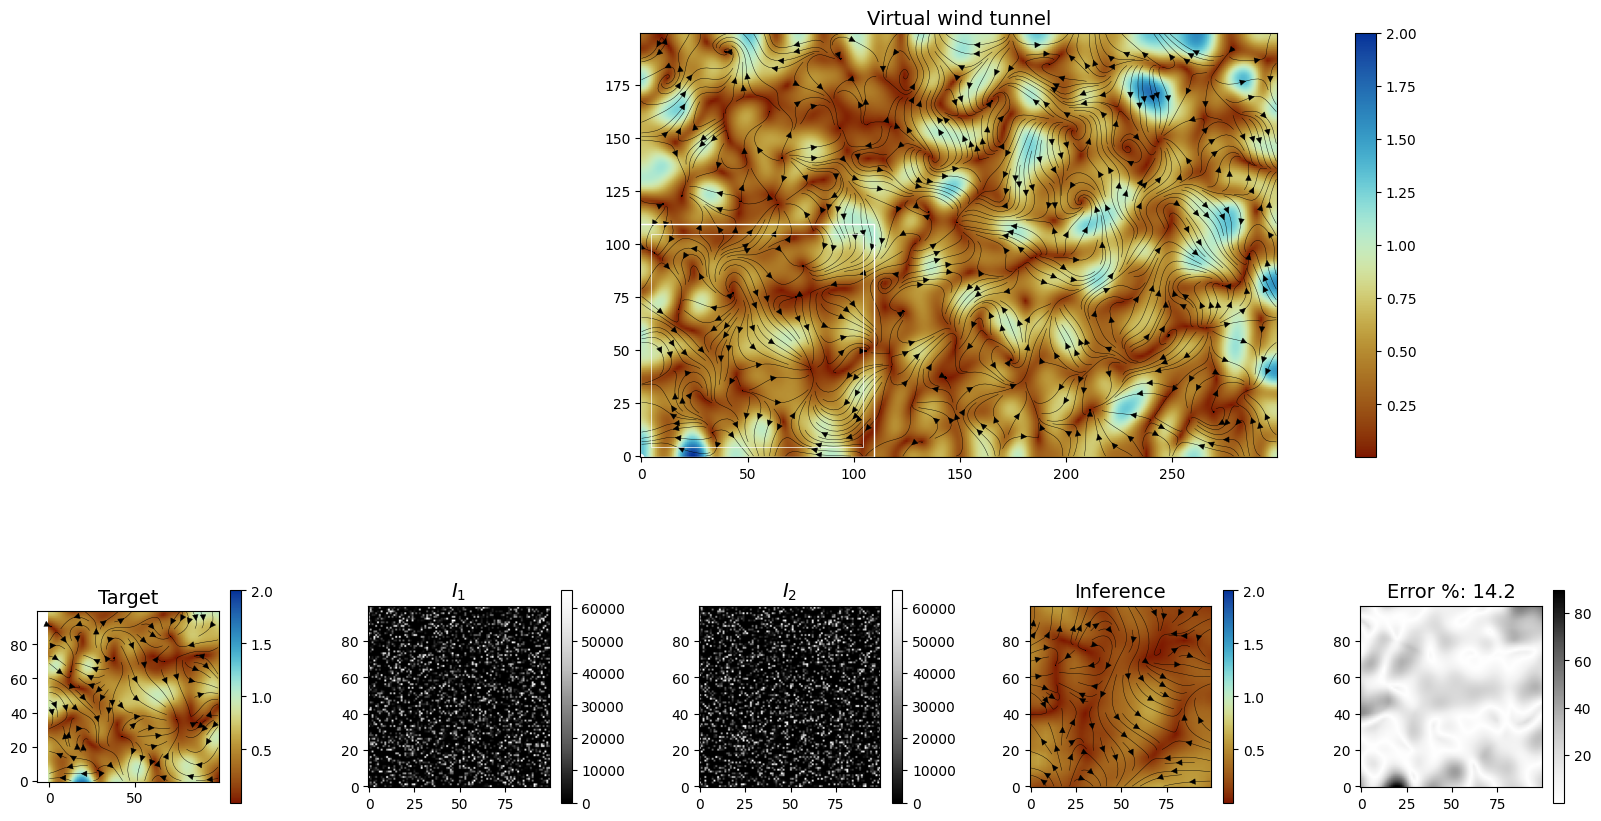

In [227]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(20,10));

In [228]:
env.targets_tensor[0,0,0,0]

-0.9122926612606228

In [230]:
env.flowfield.velocity_field[0,0,5,5]

-0.9122926612606228

***
